In [1]:
# 1. mounting google drive  
from google.colab import drive 
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [2]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer_Vision/Computer_Vision_Tasks' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['model.pth', 'MNIST_A.ipynb', '.ipynb_checkpoints', 'mnist_cnn_b.pth', 'optimizer.pth', 'MNIST_B.ipynb', 'fmnist_model.pth', 'FashionMNIST.ipynb', 'FacialEmotionRecog.ipynb', 'Caltech101.ipynb', 'Caltech101.zip', 'caltech101B.ipynb']


In [3]:
# importing libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split

from skimage import img_as_ubyte, io, color
from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import matplotlib.image as mpimg
import torch 
import torchvision 
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms 
import torch.nn as nn
import torch.optim as optim

# setting random seed for pytorch and numpy for reproducible results
torch.manual_seed(10)
np.random.seed(0)


In [4]:
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'Caltech101.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q Caltech101.zip

# Delete zipped version from Colab (not from Drive)
!rm Caltech101.zip

In [5]:
!pip install opencv-python==4.4.0.46

     |████████████████████████████████| 49.5MB 90kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [38]:
caltech_path = '/content/Caltech101'
categories = [folder for folder in sorted(os.listdir(caltech_path)) if not folder.startswith('.')]
ncategories = len(categories)
print(ncategories)

102


In [12]:
# train_imgs = []
# test_imgs = []
# train_labels = []
# test_labels = []

# for i, category in enumerate(categories):
#   counter = 0;
#   for f in os.listdir(caltech_path + "/" + category):
#     ext = os.path.splitext(f)[1]
#     #print(ext)
#     fullpath = os.path.join(caltech_path +'/' + category, f)
#     #print(fullpath)
#     label = fullpath.split(os.path.sep)[-2]
#     #print(label)
#     image = cv2.imread(fullpath)
#     image = cv2.resize(image, (150,150))
#     counter += 1
#     if (counter <=30):
#       train_imgs.append(image)
#       train_labels.append(label)
#     else:
#       test_imgs.append(image)
#       test_labels.append(label)
  
# train_imgs = np.array(train_imgs, dtype="float") / 255.0
# test_imgs = np.array(test_imgs, dtype="float") / 255.0

# lb = preprocessing.LabelBinarizer()

# train_labels_ = lb.fit_transform(train_labels)
# test_labels_ = lb.fit_transform(test_labels)

# print(len(lb.classes_))

In [26]:
images = []
labels = []

for i, category in enumerate(categories):
  for f in os.listdir(caltech_path + "/" + category):
    #ext = os.path.splitext(f)[1]
    #print(ext)
    fullpath = os.path.join(caltech_path +'/' + category, f)
    #print(fullpath)
    label = fullpath.split(os.path.sep)[-2]
    #print(label)
    image = cv2.imread(fullpath)
    image = cv2.resize(image, (100,100))
    images.append(image)
    labels.append(label)
  
images_ = np.array(images)

In [27]:
le = preprocessing.LabelEncoder()
labels_ = le.fit_transform(labels)
# targets: array([0, 1, 2, 3])

In [24]:
len(labels_)

9145

In [28]:
labels__unique , labels__unique_count = np.unique(labels_, return_counts=True)
print("Count and unique labels values in the testing set: Values:{} , Counts:{}".format(labels__unique, labels__unique_count))

Count and unique labels values in the testing set: Values:[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101] , Counts:[468 435 435 200 798  55 800  42  42  47  54  46  33 128  98  43  85  91
  50  43 123  47  59  62 107  47  69  73  70  50  51  57  67  52  65  68
  75  64  53  64  85  67  67  45  34  34  51  99 100  42  54  88  80  31
  64  86 114  61  81  78  41  66  43  40  87  32  76  55  35  39  47  38
  45  53  34  57  82  59  49  40  63  39  84  57  35  64  45  86  59  64
  35  85  49  86  75 239  37  59  34  56  39  60]


In [29]:
labels__unique , labels__unique_count = np.unique(labels, return_counts=True)
print("Count and unique labels values in the testing set: Values:{} , Counts:{}".format(labels__unique, labels__unique_count))

Count and unique labels values in the testing set: Values:['BACKGROUND_Google' 'Faces' 'Faces_easy' 'Leopards' 'Motorbikes'
 'accordion' 'airplanes' 'anchor' 'ant' 'barrel' 'bass' 'beaver'
 'binocular' 'bonsai' 'brain' 'brontosaurus' 'buddha' 'butterfly' 'camera'
 'cannon' 'car_side' 'ceiling_fan' 'cellphone' 'chair' 'chandelier'
 'cougar_body' 'cougar_face' 'crab' 'crayfish' 'crocodile'
 'crocodile_head' 'cup' 'dalmatian' 'dollar_bill' 'dolphin' 'dragonfly'
 'electric_guitar' 'elephant' 'emu' 'euphonium' 'ewer' 'ferry' 'flamingo'
 'flamingo_head' 'garfield' 'gerenuk' 'gramophone' 'grand_piano'
 'hawksbill' 'headphone' 'hedgehog' 'helicopter' 'ibis' 'inline_skate'
 'joshua_tree' 'kangaroo' 'ketch' 'lamp' 'laptop' 'llama' 'lobster'
 'lotus' 'mandolin' 'mayfly' 'menorah' 'metronome' 'minaret' 'nautilus'
 'octopus' 'okapi' 'pagoda' 'panda' 'pigeon' 'pizza' 'platypus' 'pyramid'
 'revolver' 'rhino' 'rooster' 'saxophone' 'schooner' 'scissors' 'scorpion'
 'sea_horse' 'snoopy' 'soccer_ball' 's

In [36]:
labels_map ={
0:  'BACKGROUND_Google',
1:  'Faces',
2:  'Faces_easy',
3:  'Leopards',
4:  'Motorbikes',
5:  'accordion',
6:  'airplanes',
7:  'anchor',
8:  'ant',
9:  'barrel',
10:  'bass',
11:  'beaver',
12:  'binocular',
13:  'bonsai',
14:  'brain',
15:  'brontosaurus',
16:  'buddha',
17:  'butterfly',
18:  'camera',
19:  'cannon',
20:  'car_side',
21:  'ceiling_fan',
22:  'cellphone',
23:  'chair',
24:  'chandelier',
25:  'cougar_body',
26:  'cougar_face',
27:  'crab',
28:  'crayfish',
29:  'crocodile',
30:  'crocodile_head',
31:  'cup',
32:  'dalmatian',
33:  'dollar_bill',
34:  'dolphin',
35:  'dragonfly',
36:  'electric_guitar',
37:  'elephant',
38:  'emu',
39:  'euphonium',
40:  'ewer',
41:  'ferry',
42:  'flamingo',
43:  'flamingo_head',
44:  'garfield',
45:  'gerenuk',
46:  'gramophone',
47:  'grand_piano',
48:  'hawksbill',
49:  'headphone',
50:  'hedgehog',
51:  'helicopter',
52:  'ibis',
53:  'inline_skate',
54:  'joshua_tree',
55:  'kangaroo',
56:  'ketch',
57:  'lamp',
58:  'laptop',
59:  'llama',
60:  'lobster',
61:  'lotus',
62:  'mandolin',
63:  'mayfly',
64:  'menorah',
65:  'metronome',
66:  'minaret',
67:  'nautilus',
68:  'octopus',
69:  'okapi',
70:  'pagoda',
71:  'panda',
72:  'pigeon',
73:  'pizza',
74:  'platypus',
75:  'pyramid',
76:  'revolver',
77:  'rhino',
78:  'rooster',
79:  'saxophone',
80:  'schooner',
81:  'scissors',
82:  'scorpion',
83:  'sea_horse',
84:  'snoopy',
85:  'soccer_ball',
86:  'stapler',
87:  'starfish',
88:  'stegosaurus',
89:  'stop_sign',
90:  'strawberry',
91:  'sunflower',
92:  'tick',
93:  'trilobite',
94:  'umbrella',
95:  'watch',
96:  'water_lilly',
97:  'wheelchair',
98:  'wild_cat',
99:  'windsor_chair',
100:  'wrench',
101:  'yin_yang'
}


In [30]:
print(f'Images Shape: {images_.shape}')
print(f'Labels Shape: {labels_.shape}')

Images Shape: (9145, 100, 100, 3)
Labels Shape: (9145,)


In [33]:
train_imgs, test_imgs, train_labels, test_labels = train_test_split(
    images_, labels_, test_size=0.4, shuffle=True, stratify=labels_)

In [34]:
print("Shape of train_imgs: {} , shape of test_imgs: {}".format(train_imgs.shape, test_imgs.shape))
print("Shape of train_labels: {} , shape of test_labels: {}".format(train_labels.shape, test_labels.shape))
print("train_imgs min,max values: {},{} , test_imgs min,max values: {},{}".format(np.min(train_imgs), np.max(train_imgs) , np.min(test_imgs), np.max(test_imgs) ))

Shape of train_imgs: (5487, 100, 100, 3) , shape of test_imgs: (3658, 100, 100, 3)
Shape of train_labels: (5487,) , shape of test_labels: (3658,)
train_imgs min,max values: 0,255 , test_imgs min,max values: 0,255


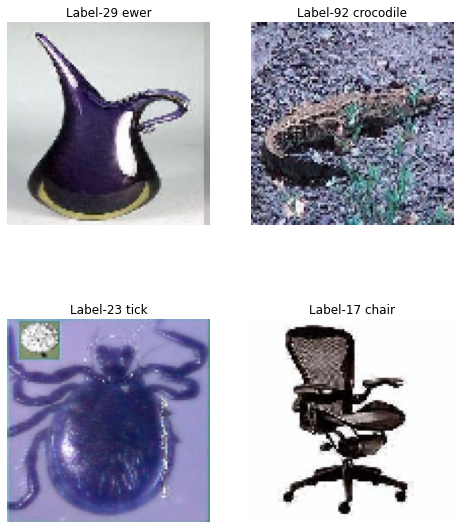

In [37]:
num_rows = 2
num_cols = 2
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize =(8, 10), sharex=True, sharey=True)
ax = axes.ravel()

idxs = np.random.choice(len(train_imgs), (num_rows*num_cols,))
for i, idx in enumerate(idxs):
  ax[i].imshow(train_imgs[i])
  ax[i].set_title('Label-{} {}'.format(train_labels[i+1], labels_map[train_labels[i]]))
  ax[i].set_axis_off()
  # fig.tight_layout()
plt.show()

In [ ]:
class createDataset(Dataset) :
  def __init__(self, imgs_arr, labels_arr):
    super(createDataset, self).__init__()
    self.imgs_arr   = imgs_arr
    self.labels_arr = labels_arr 
    
    # transforms.ToTensor() transformation converts numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    #self.transform = transforms.ToTensor() 
    self.transform = transforms.ToTensor() 

  def __getitem__(self, index):
    x = self.imgs_arr[index]
    x = self.transform(x)
    y = self.labels_arr[index]
    y = torch.tensor(y)
    return x,y

  def __len__(self):
    return len(self.labels_arr)



In [ ]:
train_dataset = createDataset(train_imgs, train_labels)
test_dataset  = createDataset(test_imgs, test_labels)

In [ ]:
# setting some hyperparameters
train_batch_size = 32
test_batch_size  = 32
learning_rate = 0.001
momentum=0.5
n_epochs = 3

In [ ]:
# creating train and test set dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=2)
test_dataloader  = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=2)

torch.Size([32, 3, 100, 100]) torch.Size([32])
tensor(0.) tensor(1.)


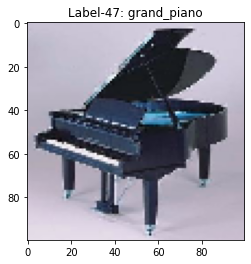

In [ ]:
# visualizing a sample image from the dataset (also, for verifying correctness of the dataloader)
sample_imgs, sample_labels = next(iter(test_dataloader))
print(sample_imgs.shape, sample_labels.shape)
print(torch.min(sample_imgs), torch.max(sample_imgs))
sample_img = sample_imgs[0].permute(1,2,0) #100 x 100 x 3
sample_label = sample_labels[0]
plt.imshow(sample_img)
plt.title("Label-{}: {}".format(sample_label, labels_map[sample_label.item()]))
plt.show()

In [ ]:
class cnn_model(nn.Module):
  def __init__(self, num_classes=102) :
    super(cnn_model, self).__init__()
    self.num_classes = num_classes
    self.base_layer = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1), #150
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1), #150
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2), # 75

        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1, stride=1), # 75
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 32),
        nn.MaxPool2d(2), # 37 or 38

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1), # 37
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(2), # (25-2)//2 + 1 = 18
        nn.Dropout(0.25),

        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1), #18
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(num_features= 64),
        nn.MaxPool2d(2), #9*9*64
        nn.Dropout(0.25),

        )
    
    self.classifier_layer = nn.Sequential(
        nn.Linear(in_features= 2304, out_features= 256), # updated number of out_features # 6*6*64
        nn.ReLU(inplace=True),
        nn.BatchNorm1d(num_features= 256),  # updated number of num_features
        nn.Dropout(0.5),  
        nn.Linear( in_features= 256, out_features= self.num_classes)    # updated number of in_features
        )      
        
  def forward(self,x) :
    x = self.base_layer(x)
    x = x.reshape(x.size(0),-1)
    out = self.classifier_layer(x)
    return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Device used is {}".format(device))
model = cnn_model()
model.to(device) # send model to device/GPU for training 

Device used is cuda


cnn_model(
  (base_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): MaxPool2d(ke

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
len(train_dataloader)

172

In [ ]:
# Train the model
total_step = len(train_dataloader)
loss_list = []
acc_list = []
for epoch in range(n_epochs):
  for i, (images, labels) in enumerate(train_dataloader):
    #Run the forward pass
    # images = images.cuda()
    # label = labels.cuda()
    images, labels = next(iter(train_dataloader))    
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    # outputs = outputs.to(device)
    loss = criterion(outputs, labels)
    loss_list.append(loss.item())

    # Backprop and perform Adam optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track the accuracy
    total = labels.size(0)
    _, predicted = torch.max(outputs.data,dim=1)
    correct = (predicted == labels).sum().item()
    acc_list.append(correct / total)

    if (i + 1) % 50 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
              .format(epoch + 1, n_epochs, i + 1, total_step, loss.item(),
                      (correct / total) * 100))

Epoch [1/3], Step [50/172], Loss: 1.7870, Accuracy: 53.12%
Epoch [1/3], Step [100/172], Loss: 1.5596, Accuracy: 62.50%
Epoch [1/3], Step [150/172], Loss: 1.0581, Accuracy: 78.12%
Epoch [2/3], Step [50/172], Loss: 1.2626, Accuracy: 81.25%
Epoch [2/3], Step [100/172], Loss: 1.4571, Accuracy: 62.50%
Epoch [2/3], Step [150/172], Loss: 0.9465, Accuracy: 84.38%
Epoch [3/3], Step [50/172], Loss: 0.7804, Accuracy: 78.12%
Epoch [3/3], Step [100/172], Loss: 0.8645, Accuracy: 78.12%
Epoch [3/3], Step [150/172], Loss: 1.1340, Accuracy: 78.12%
